In [46]:
from obspy import read
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Ruta al archivo .mseed
data_directory = '../../data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1972-05-11HR00_evid00055.mseed'

mseed_file = f'{data_directory}'

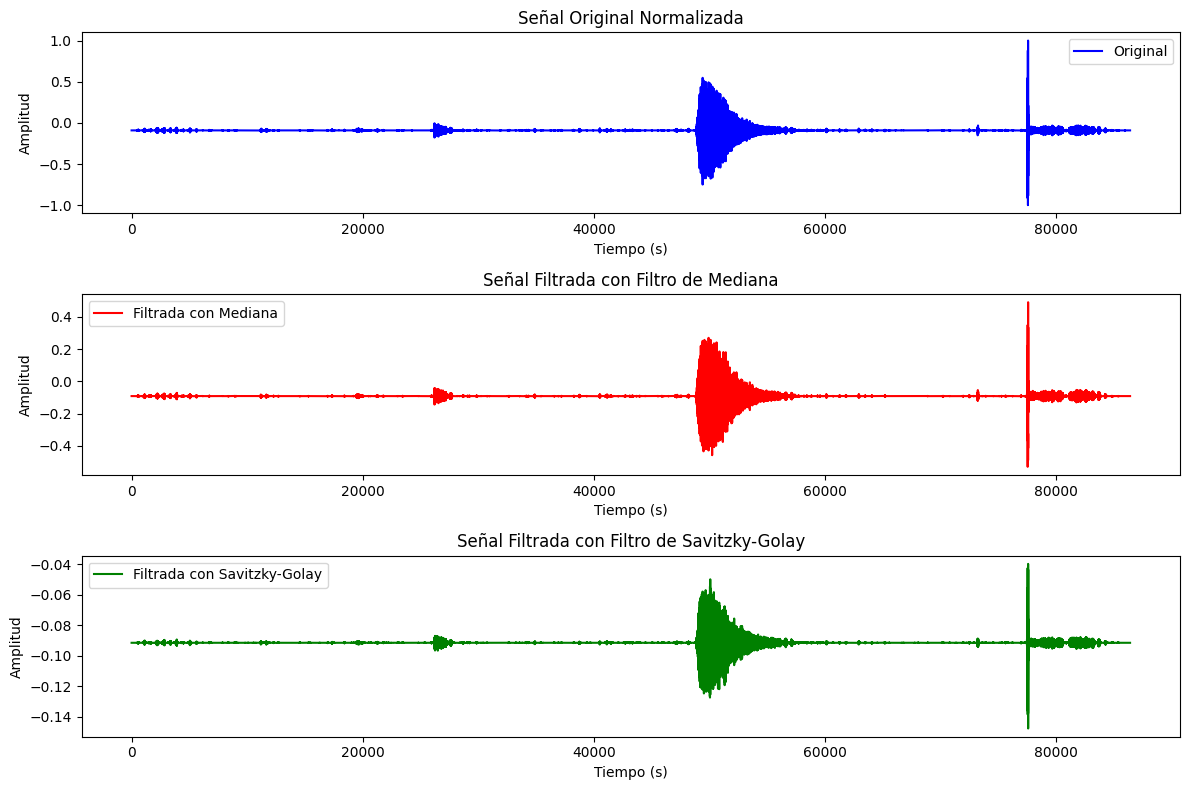

In [47]:
from scipy.signal import medfilt, savgol_filter
import matplotlib.pyplot as plt
import numpy as np
from obspy import read

# Leer el archivo mseed
st = read(mseed_file)
tr = st[0].copy()  # Obtener la primera traza

# Aplicar el filtro de banda
minfreq = 0.5
maxfreq = 6
tr.filter('bandpass', freqmin=minfreq, freqmax=maxfreq)

# Obtener datos de la traza filtrada
tr_times = tr.times()
tr_data = tr.data

# Normalización Min-Max
min_val = np.min(tr_data)
max_val = np.max(tr_data)
tr_data_minmax = 2 * (tr_data - min_val) / (max_val - min_val) - 1  # Escalado entre -1 y 1

# 1. Aplicar un Filtro de Mediana
tr_data_median_filtered = medfilt(tr_data_minmax, kernel_size=5)  # Tamaño del kernel ajustable

# 2. Aplicar un Filtro de Savitzky-Golay
tr_data_savgol_filtered = savgol_filter(tr_data_minmax, window_length=51, polyorder=3)  # Tamaño de la ventana y orden del polinomio ajustables

# Visualizar las señales
plt.figure(figsize=(12, 8))

# Señal original
plt.subplot(3, 1, 1)
plt.plot(tr_times, tr_data_minmax, 'b-', label='Original')
plt.title('Señal Original Normalizada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

# Señal Filtrada con Mediana
plt.subplot(3, 1, 2)
plt.plot(tr_times, tr_data_median_filtered, 'r-', label='Filtrada con Mediana')
plt.title('Señal Filtrada con Filtro de Mediana')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

# Señal Filtrada con Savitzky-Golay
plt.subplot(3, 1, 3)
plt.plot(tr_times, tr_data_savgol_filtered, 'g-', label='Filtrada con Savitzky-Golay')
plt.title('Señal Filtrada con Filtro de Savitzky-Golay')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()

[array([326340, 331262], dtype=int64)]


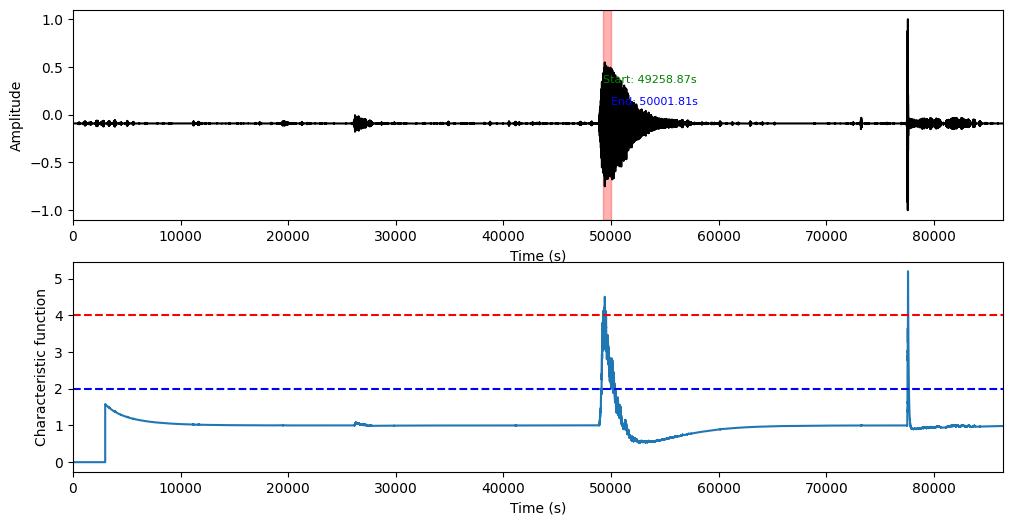

In [48]:
from obspy.signal.trigger import recursive_sta_lta, trigger_onset
import matplotlib.pyplot as plt
import numpy as np

l_threshold_on = [8, 4, 2, 1.8, 1.5, 1.3, 1.15]
l_threshold_off = [2, 2, 1, 1, 1, 1, 0]
merged_on_off = []
x, y = 0, 0
min_duration_seconds = 350  # Duración mínima en segundos
min_gap_seconds = 5  # Mínima diferencia entre eventos en segundos

while merged_on_off == [] and x < len(l_threshold_on):
    df = tr.stats.sampling_rate
    # Aplicar un filtro de banda antes del análisis
    tr.filter('bandpass', freqmin=minfreq, freqmax=maxfreq)  # Ajustar el filtro de banda

    # Longitudes de ventana STA/LTA en segundos
    sta_len = 60  # Ventana de corto plazo
    lta_len = 3000  # Ventana de largo plazo

    # Ejecutar STA/LTA recursivo
    cft = recursive_sta_lta(tr_data_minmax, int(sta_len * df), int(lta_len * df))

    # Definir umbrales para la detección (ajustados)
    threshold_on = l_threshold_on[x]  # Incrementar umbral de activación
    threshold_off = l_threshold_off[y]  # Incrementar umbral de desactivación

    # Detectar eventos
    on_off = trigger_onset(cft, threshold_on, threshold_off)

    # Filtrar detecciones cortas (menos de la duración mínima especificada)
    min_duration = min_duration_seconds * df
    on_off_filtered = [event for event in on_off if (event[1] - event[0]) > min_duration]

    # Fusionar detecciones cercanas (si la diferencia entre ellas es menor a un cierto tiempo)
    min_gap = min_gap_seconds * df  # Convertir segundos a muestras
    merged_on_off = []
    if len(on_off_filtered) > 0:
        current_event = on_off_filtered[0]
        for i in range(1, len(on_off_filtered)):
            if on_off_filtered[i][0] - current_event[1] < min_gap:
                current_event[1] = on_off_filtered[i][1]  # Fusionar eventos
            else:
                merged_on_off.append(current_event)
                current_event = on_off_filtered[i]
        merged_on_off.append(current_event)
    x += 1
    y += 1

# Visualizar la función característica y las detecciones
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Gráfico de la señal con detecciones
ax[0].plot(tr.times(), tr_data_minmax, 'k')  # Usar la señal normalizada
for start, end in merged_on_off:
    # Convertir índices a tiempo en segundos
    start_time = start / df
    end_time = end / df
    
    # Resaltar el intervalo detectado
    ax[0].axvspan(tr.times()[start], tr.times()[end], color='red', alpha=0.3)
    
    # Anotar el tiempo de inicio y fin
    ax[0].text(tr.times()[start], tr_data_minmax[start], f'Start: {start_time:.2f}s', color='green', fontsize=8, verticalalignment='bottom')
    ax[0].text(tr.times()[end], tr_data_minmax[end], f'End: {end_time:.2f}s', color='blue', fontsize=8, verticalalignment='top')

ax[0].set_xlim([min(tr.times()), max(tr.times())])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

# Gráfico de la función característica STA/LTA
ax[1].plot(tr.times(), cft)
ax[1].axhline(y=threshold_on, color='r', linestyle='--')
ax[1].axhline(y=threshold_off, color='b', linestyle='--')
ax[1].set_xlim([min(tr.times()), max(tr.times())])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Characteristic function')

print(merged_on_off)

plt.show()


In [49]:
i=0

for start_test,end_test in merged_on_off:
    i+=1
    print(f'{i}. Event detected at {start_test/df} s - {end_test/df} s')

1. Event detected at 49258.8679245283 s - 50001.811320754714 s
